In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, accuracy_score

from mlxtend.plotting import plot_decision_regions
## pip install mlxtend
from sklearn.model_selection import cross_val_score
from sklearn import utils


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# Merkmalsreduktion
# Schneide irrelevante Informationen aus dem Bilder heraus.
# Speichere die Merkalsreduzierten Bilder in einen neuen Ordner /data/

all_dogs = 0  # Zählvariable der Hundebilder 
data_dir = os.getcwd() + '\\'
breed_list = os.listdir(data_dir + 'images\\Images\\')
os.makedirs('data', exist_ok=True)


for breed in breed_list:
    os.makedirs('data\\' + breed, exist_ok=True)
for breed in os.listdir('data'):
    for file in os.listdir(data_dir + 'annotation\\Annotation\\' + breed):
        img = Image.open(data_dir + 'images\\Images\\' + breed + '\\' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotation\\Annotation\\' + breed + '\\' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data//' + breed + '/' + file + '.jpg')
        all_dogs = all_dogs+1

In [3]:
#lese daten  in "bilder aka imagepath array ein und der dazugehörigen daten aka label_array"
# Speichere die Bilddaten (RGB Werte) in ein array
# Speichere die Hunderassen in 
SCALE = 150 # Setzte Skalierungsfaktor auf welchen die Bilder alle Skaliert werden
data_array = []
label_array= []
breedNum = 0
for breed in breed_list:
    imagepath=(data_dir + 'data\\' + breed )
    for img in os.listdir(imagepath):
        img_array=cv2.imread(os.path.join(imagepath,img))
        #data_array.append(img_array.tolist())
        data_array.append(cv2.resize(img_array,(SCALE,SCALE)).tolist())
        label_array.append(breedNum) # Setze Hunderasseart auf eine ID
    breedNum = breedNum + 1

In [4]:
#reshape und skaliere alle Bilder
data_array = np.array(data_array)
data_array = data_array.reshape(len(data_array), 3, SCALE, SCALE).transpose(0,2,3,1)

In [5]:
# Feature Extraktion 
data_features = []
for i in range(0, all_dogs):
    img = data_array[i]
    features = np.array([None] * 2)
    features[0] = np.mean(img[:, :, 0]) # Extrahiere average HUE Wert
    features[1] = np.mean(img[:, :, 1]) # Extrahiere Saturations Wert
    data_features.append(features.tolist()) 

# Mit dem MinMaxScaler verschlechtert sich die Model accuracy oder sie wird nur geringfügig verbessert
#scaler = MinMaxScaler() # normalisiert die Werte
#scaler.fit(data_features)

In [6]:

#### Schuffel einschalten###
label_array, data_features = utils.shuffle(label_array, data_features)

# Einteilen der TEST und TRAIN Daten
size_of_train= int(all_dogs*0.75)
size_of_test = int(all_dogs*0.25)

X_train = data_features[:size_of_train]
X_test = data_features[-size_of_test:]

Y_train = label_array[:size_of_train]
Y_test = label_array[-size_of_test:]

In [7]:
# Umbennenen der Hunderassen. (Scheide Ziffern weg) 
# Zu besseren Darstellung in den Legenden der folgenden Schaubilder
for i in range(0, len(breed_list)):
    ar = breed_list[i].split('-')
    breed_list[i] = ar[1]

In [8]:
# Create the SVM
svm = SVC(kernel='rbf', gamma='scale')

# Fit the data to the SVM classifier
svm = svm.fit(X_train, Y_train)

# Generate predictions
y_pred = svm.predict(X_test)

# Evaluate by means of accuracy
accuracy = accuracy_score(Y_test, y_pred)
print(f'Model accuracy: {accuracy}')

vscores = cross_val_score(svm, X_test, Y_test, cv=3)
print('\nCross-Validation-Score 3-fold')
print(vscores)

Model accuracy: 0.47417840375586856

Cross-Validation-Score 3-fold
[0.47887324 0.38028169 0.50704225]


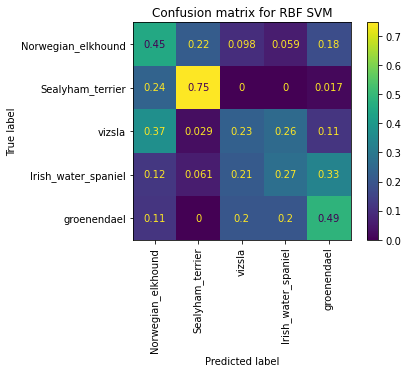

In [9]:
# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm, X_test, Y_test,
                                 normalize='true',
                                 display_labels= breed_list
                                 )
plt.title('Confusion matrix for RBF SVM')
plt.xticks(rotation=90)

plt.show(matrix)
plt.show()


Decision boundary:


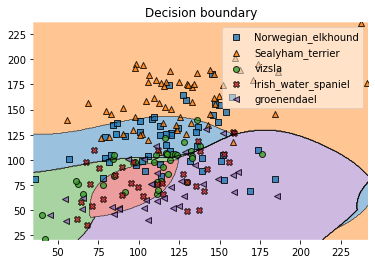

In [10]:
# Plot decision boundary
print('Decision boundary:')
ax = plot_decision_regions(np.array(X_test), np.array(Y_test), clf=svm, markers= "s^oX<")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          breed_list, 
          framealpha=0.5, 
          scatterpoints=1)

plt.title('Decision boundary')
plt.show()